# 2.4 생성된 답변을 여러번 검증하는 Self-RAG

- [Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection](https://arxiv.org/abs/2310.11511)논문을 구현합니다
- LangGraph 공식문서에 나온 흐름을 따라갑니다
![self-rag](https://i.imgur.com/X11ND6N.png)

In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str 
    
graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [7]:
from langchain import hub

# 허브에서 RAG 프롬프트를 가져옵니다
generate_prompt = hub.pull("rlm/rag-prompt")

# 지정된 매개변수로 언어 모델을 초기화합니다
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    # state에서 컨텍스트와 쿼리를 추출합니다
    context = state['context']
    query = state['query']
    
    # 작업 체인을 생성합니다: 먼저 프롬프트를 검색하고, 그 다음 응답을 생성합니다
    rag_chain = generate_prompt | generate_llm
    
    # 쿼리와 컨텍스트로 체인을 호출하여 응답을 얻습니다
    response = rag_chain.invoke({'question': query, 'context': context})
    
    # 생성된 답변을 반환합니다
    return {'answer': response.content}

- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 질문에 답변할 수 없다고 판단하고 마무리합니다
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성합니다

In [8]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'
    
    return 'irrelevant'

In [9]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}


- 답변이 `retrieve` 노드에서 추출된 문서와 관련이 있는지 판단합니다
    - 문서와 관련이 없다면 `generate` 노드로 이동해서 답변을 다시 생성합니다
    - 문서와 관련이 있다면 `check_helpfulness` 노드로 이동해서 답변이 도움이 되는지 판단합니다

In [10]:
# set the LANGCHAIN_API_KEY environment variable (create key in settings)
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal['hallucinated', 'not hallucinated']:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    return response

In [13]:
# # test
# query = "연봉 5천만원 거주자의 소득세는 얼마인가요?"
# context = retriever.invoke(query)

# print('documents')

# for document in context:
#     print(document.page_content)

# print('documents')

# generate_state = {'query': query, 'context': context}
# answer = generate(generate_state)['answer']

# hallucination_state = {'answer': answer, 'context': context}

# check_hallucination(hallucination_state)

documents
② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>
  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. 
[개정 2014. 1. 1.]
[전문개정 2009. 12. 31.]
[제목개정 2014. 1. 1.]
제2절 세액의 계산 <개정 2009. 12. 31.>
제1관 세율 <개정 2009. 12. 31.>
제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>
종합소득
┌───────────────┐
│ 과세표준의 6개 구간 │
├───────────────┤
│ 1,400만원 이하        │ 84만원 + (1,400만원을 초과하는 금액의 15%)  │
│ 1,400만원 초과        │ 84만원 + (5,000만원을 초과하

'not hallucinated'

- 생성된 답변이 사용자의 질문과 관련이 있는지 판단합니다
    - 질문과 관련이 있다면 사용자에게 답변을 리턴합니다
    - 질문과 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경합니다
        - `rewrite` 후 다시 `retrieve` 합니다

- 섹션 3에 나오는 것처럼 `check_helpfulness` node를 생성하지 않고 `check_helpfulness_grader`만 추가해서 `conditional_edge`로 사용할 수도 있습니다

In [14]:
from langchain import hub

# LangChain 허브에서 유용성 프롬프트를 가져옵니다
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> str:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.

    Args:
        state (AgentState): 사용자의 질문과 생성된 답변을 포함한 에이전트의 현재 state.

    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다.
    """
    # state에서 질문과 답변을 추출합니다
    query = state['query']
    answer = state['answer']

    # 답변의 유용성을 평가하기 위한 체인을 생성합니다
    helpfulness_chain = helpfulness_prompt | llm
    
    # 질문과 답변으로 체인을 호출합니다
    response = helpfulness_chain.invoke({'question': query, 'student_answer': answer})

    # 점수가 1이면 'helpful'을 반환하고, 그렇지 않으면 'unhelpful'을 반환합니다
    if response['Score'] == 1:
        return 'helpful'
    
    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState:
    """
    유용성을 확인하는 자리 표시자 함수입니다. 
    graph에서 conditional_edge를 연속으로 사용하지 않고 node를 추가해
    가독성을 높이기 위해 사용합니다

    Args:
        state (AgentState): 에이전트의 현재 state.

    Returns:
        AgentState: 변경되지 않은 state를 반환합니다.
    """
    # 이 함수는 현재 아무 작업도 수행하지 않으며 state를 그대로 반환합니다
    return state

- `node`를 추가하고 `edge`로 연결합니다

In [15]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [16]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance, 
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [17]:
graph = graph_builder.compile()

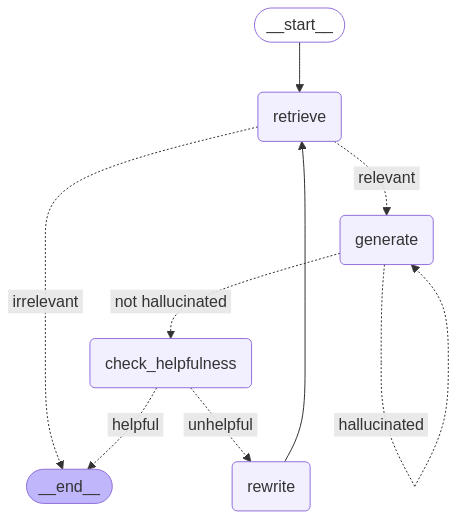

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)